In [1]:
import pandas as pd

In [2]:
df_llms_performance = pd.read_csv("../performance_statistics/overall_statistics.csv")

df_llms_performance.head()

,Model,Accuracy,TN,FP,FN,TP,MCC
0,model_albert_base_0.0001_512_dataset_preproces...,0.55,0,4244,0,5134,0.000000
1,model_albert_base_0.0001_512_dataset_preproces...,0.55,0,4237,0,5141,0.000000
2,model_albert_base_2e-05_512_dataset_preprocess...,0.73,2995,1249,1243,3891,0.463648
3,model_albert_base_2e-05_512_dataset_preprocess...,0.70,2773,1464,1343,3798,0.394364
4,model_albert_base_5e-05_512_dataset_preprocess...,0.55,0,4244,0,5134,0.000000


In [3]:
def extract_info(df):
    
    df['Modelname'] = df['Model'].apply(lambda x: "_".join(x.split("_")[1:x.split("_").index('dataset') - 2]))
    df['Max_length'] = df['Model'].apply(lambda x: int(x.split("_")[x.split("_").index('dataset') - 1]))
    df['Learning_rate'] = df['Model'].apply(lambda x: float(x.split("_")[x.split("_").index('dataset') - 2]))
    df['Dataset'] = df['Model'].apply(lambda x: "_".join(x.split("_")[x.split("_").index('dataset') + 1:]))

    df.drop('Model', axis=1, inplace=True)

    df = df[['Modelname', 'Max_length', 'Learning_rate', 'Dataset', 'Accuracy', 'TN', 'FP', 'FN', 'TP', 'MCC']]
    # Return the modified DataFrame
    return df

# Apply the function to your DataFrame
df_llms_performance = extract_info(df_llms_performance.copy())  # Operate on a copy to avoid modifying original data
df_llms_performance.head()

,Modelname,Max_length,Learning_rate,Dataset,Accuracy,TN,FP,FN,TP,MCC
0,albert_base,512,0.00010,preprocessed_no_transformation,0.55,0,4244,0,5134,0.000000
1,albert_base,512,0.00010,preprocessed_stopwords,0.55,0,4237,0,5141,0.000000
2,albert_base,512,0.00002,preprocessed_no_transformation,0.73,2995,1249,1243,3891,0.463648
3,albert_base,512,0.00002,preprocessed_stopwords,0.70,2773,1464,1343,3798,0.394364
4,albert_base,512,0.00005,preprocessed_no_transformation,0.55,0,4244,0,5134,0.000000


In [5]:
df_llms_performance.sort_values(by = 'Accuracy', ascending = False)

,Modelname,Max_length,Learning_rate,Dataset,Accuracy,TN,FP,FN,TP,MCC
49,transformer,512,0.00002,preprocessed_no_transformation,0.82,3357,887,815,4319,0.633261
37,roberta,512,0.00002,preprocessed_no_transformation,0.81,3251,993,821,4313,0.608665
19,bert_base,256,0.00002,preprocessed_no_transformation,0.80,3208,1036,877,4257,0.587321
46,roberta,256,0.00002,preprocessed_no_transformation,0.80,3151,1093,818,4316,0.587465
13,bert_base,512,0.00002,preprocessed_no_transformation,0.80,3255,989,888,4246,0.595370
31,distilbert,256,0.00002,preprocessed_no_transformation,0.78,3159,1085,968,4166,0.557307
25,distilbert,512,0.00002,preprocessed_no_transformation,0.78,3164,1080,966,4168,0.558835
15,bert_base,512,0.00002,preprocessed_stopwords,0.75,3115,1122,1212,3929,0.498600
34,distilbert,256,0.00002,preprocessed_stopwords,0.75,3022,1215,1162,3979,0.487783
44,roberta,256,0.00002,preprocessed_stopwords,0.75,2973,1264,1109,4032,0.487800


In [4]:
df_llms_performance.groupby(['Dataset', 'Max_length', 'Learning_rate', 'Modelname'])[['Accuracy', 'MCC']].mean()

Accuracy  \
Dataset                        Max_length Learning_rate Modelname               
preprocessed_no_transformation 256        0.00002       albert_base      0.72   
                                                        bert_base        0.80   
                                                        distilbert       0.78   
                                                        roberta          0.80   
                                                        transformer      0.70   
                                          0.00005       albert_base      0.55   
                                                        bert_base        0.55   
                                                        distilbert       0.74   
                                                        roberta          0.55   
                                                        transformer      0.55   
                                          0.00010       albert_base      0.55   
                                                        bert_base        0.55   
                                                        distilbert       0.55   
                                                        roberta          0.55   
                                                        transformer      0.55   
                               512        0.00002       albert_base      0.73   
                                                        bert_base        0.80   
                                                        distilbert       0.78   
                                                        roberta          0.81   
                                                        transformer      0.82   
                                          0.00005       albert_base      0.55   
                                                        bert_base        0.55   
                                                        distilbert       0.74   
                                                        roberta          0.55   
                                                        transformer      0.55   
                                          0.00010       albert_base      0.55   
                                                        bert_base        0.55   
                                                        distilbert       0.55   
                                                        roberta          0.55   
                                                        transformer      0.55   
preprocessed_stopwords         256        0.00002       albert_base      0.72   
                                                        bert_base        0.75   
                                                        distilbert       0.75   
                                                        roberta          0.75   
                                                        transformer      0.55   
                                          0.00005       albert_base      0.72   
                                                        bert_base        0.55   
                                                        distilbert       0.72   
                                                        roberta          0.55   
                                                        transformer      0.55   
                                          0.00010       albert_base      0.63   
                                                        bert_base        0.55   
                                                        distilbert       0.55   
                                                        roberta          0.55   
                                                        transformer      0.55   
                               512        0.00002       albert_base      0.70   
                                                        bert_base        0.75   
                                                        distilbert       0.75   
                   

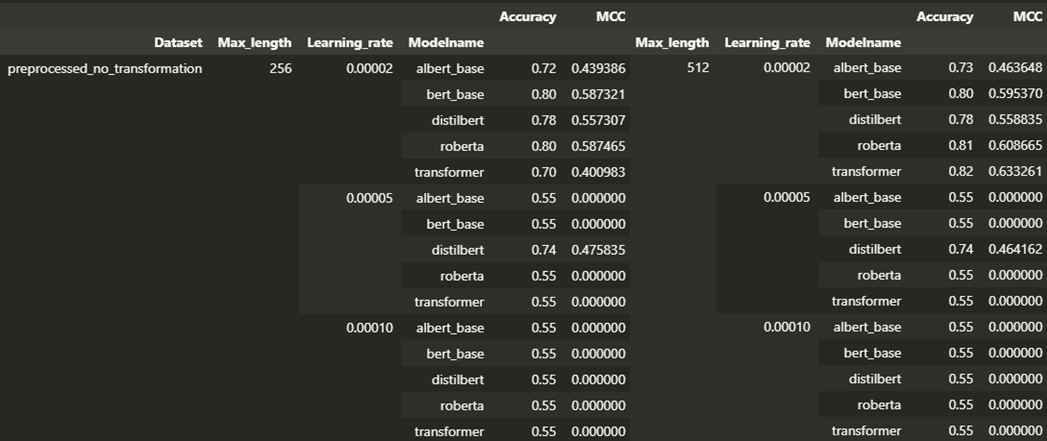